## 데이터 전처리

In [1]:
import pandas as pd
import numpy as np

bank_df = pd.read_csv('bank.csv')
del bank_df['previous']
del bank_df['campaign']
del bank_df['poutcome']
del bank_df['pdays']
del bank_df['month']

# 2가지 범주 숫자화
yesno_mapping = {'no':0, 'yes':1}

bank_df['deposit'] = bank_df['deposit'].map(yesno_mapping)
bank_df['default'] = bank_df['default'].map(yesno_mapping)
bank_df['housing'] = bank_df['housing'].map(yesno_mapping)
bank_df['loan'] = bank_df['loan'].map(yesno_mapping)

# 3~4가지 범주 숫자화
contact_mapping = {'cellular':1, 'unknown':2, 'telephone':3}
bank_df['contact'] = bank_df['contact'].map(contact_mapping)
marital_mapping = {'married':1, 'single':2, 'divorced':3}
bank_df['marital'] = bank_df['marital'].map(marital_mapping)
education_mapping = {'secondary':1, 'tertiary':2, 'primary':3, 'unknown':4}
bank_df['education'] = bank_df['education'].map(education_mapping)

# 나이 범주화
bank_df.loc[ bank_df['age'] <= 16, 'age'] = 0,
bank_df.loc[(bank_df['age'] > 16) & (bank_df['age'] <= 32), 'age'] = 1,
bank_df.loc[(bank_df['age'] > 32) & (bank_df['age'] <= 48), 'age'] = 2,
bank_df.loc[(bank_df['age'] > 48) & (bank_df['age'] <= 64), 'age'] = 3,
bank_df.loc[ bank_df['age'] > 64, 'age'] = 4

list_job = bank_df['job'].unique()
job_mapping = {}
for index in range(len(list_job)):
    job_mapping[list_job[index]] = index
    
bank_df['job'] = bank_df['job'].map(job_mapping)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(bank_df[['balance']])
bank_df['balance'] = scaler.transform(bank_df[['balance']])
scaler.fit(bank_df[['duration']])
bank_df['duration'] = scaler.transform(bank_df[['duration']])

bank_df.head()

C:\Users\bruce0809\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\bruce0809\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
C:\Users\bruce0809\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\bruce0809\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


,age,job,marital,education,default,balance,housing,loan,contact,day,duration,deposit
0,3,0,1,1,0,0.252525,1,0,2,5,1.930226,1
1,3,0,1,1,0,-0.459974,0,0,2,5,3.154612,1
2,2,1,1,1,0,-0.080160,1,0,2,5,2.929901,1
3,3,2,1,1,0,0.293762,1,0,2,5,0.596366,1
4,3,0,1,2,0,-0.416876,0,0,2,5,0.867171,1


## 모델링 전 데이터 나누기

In [2]:
target = bank_df['deposit']
data = bank_df.iloc[:, 0:-1]

x_data = np.array(data)
y_data = np.array(target)
y_data = np.reshape(y_data, [len(y_data), 1])

from sklearn import preprocessing
enc = preprocessing.OneHotEncoder(categories='auto')
enc.fit(y_data)
y_data = enc.transform(y_data) 
y_data = y_data.toarray()
y_data

from sklearn import model_selection
train_data, test_data, train_label, test_label = model_selection.train_test_split(x_data, y_data,
                                                                                 test_size=0.3,
                                                                                 random_state=0)

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import layers
import os
tf.logging.set_verbosity(tf.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## 모델링 작업

In [3]:
X = tf.placeholder(tf.float32, [None, 11])  # number of X_data's columns
Y = tf.placeholder(tf.float32, [None, 2])  # number of Y_data's columns (one-hot vector)
bn_sign = tf.placeholder(tf.bool)

# contrib는 2점대 버전에서 없어질 함수
L1 = layers.dense(X, 256, activation=tf.nn.relu, kernel_initializer=tf.keras.initializers.he_normal())
L1 = tf.layers.batch_normalization(L1, training=bn_sign)

L2 = layers.dense(L1, 256, activation=tf.nn.relu, kernel_initializer=tf.keras.initializers.he_normal())
L2 = tf.layers.batch_normalization(L2, training=bn_sign)

model = layers.dense(L2, 2, activation=None)

cost = tf.losses.softmax_cross_entropy(Y, model)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(1e-2).minimize(cost)
    
is_correct = tf.equal(tf.argmax(model, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

batch_size = 100
total_batch = len(bank_df) // batch_size
total_batch

111

In [5]:
def shuffle_batch(X, Y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, Y_batch = X[batch_idx], Y[batch_idx]
        yield X_batch, Y_batch
        
epoch_list = []
cost_list = []
train_acc_list = []
test_acc_list = []
        
for epoch in range(15):
    train_cp = []  # Training accuracy 를 동시에 출력해보도록 합니다.
    total_cost = 0
    test_cp = []
    for batch_xs, batch_ys in shuffle_batch(train_data, train_label, batch_size): 
        
        _, cost_val = sess.run([optimizer, cost], feed_dict={X: batch_xs, Y: batch_ys, bn_sign: True})
        
        # 매 Epoch마다 Total cost를 출력합니다.
        total_cost += cost_val # cost

        # 매 Epoch마다 Training accuracy를 출력합니다. (bn_sign을 False로 바꾸어 training mode가 아닌 inference mode로 실행합니다.)
        train_cp = sess.run([is_correct], feed_dict={X: batch_xs, Y: batch_ys, bn_sign: False}) # Training accuracy
        test_cp =sess.run(accuracy, feed_dict={ X: test_data, Y: test_label, bn_sign: False})

    epoch_list.append(epoch)
    cost_list.append(total_cost / total_batch)
    train_acc_list.append(np.mean(train_cp))
    test_acc_list.append(test_cp)
    print('Epoch:', '%04d' % (epoch + 1), 
          '|| Avg. cost =', '{:.3f}'.format(total_cost / total_batch), # cost
          '|| Training accuracy : {:.3f}'.format(np.mean(train_cp)),   # Training accuracy
          '|| Test accuracy : {:.3f}'.format(test_cp)) 

print('Learning process is completed!')

Epoch: 0001 || Avg. cost = 0.444 || Training accuracy : 0.880 || Test accuracy : 0.755
Epoch: 0002 || Avg. cost = 0.352 || Training accuracy : 0.690 || Test accuracy : 0.737
Epoch: 0003 || Avg. cost = 0.346 || Training accuracy : 0.800 || Test accuracy : 0.762
Epoch: 0004 || Avg. cost = 0.341 || Training accuracy : 0.770 || Test accuracy : 0.782
Epoch: 0005 || Avg. cost = 0.337 || Training accuracy : 0.750 || Test accuracy : 0.770
Epoch: 0006 || Avg. cost = 0.343 || Training accuracy : 0.800 || Test accuracy : 0.757
Epoch: 0007 || Avg. cost = 0.333 || Training accuracy : 0.760 || Test accuracy : 0.766
Epoch: 0008 || Avg. cost = 0.329 || Training accuracy : 0.820 || Test accuracy : 0.758
Epoch: 0009 || Avg. cost = 0.322 || Training accuracy : 0.770 || Test accuracy : 0.776
Epoch: 0010 || Avg. cost = 0.324 || Training accuracy : 0.720 || Test accuracy : 0.780
Epoch: 0011 || Avg. cost = 0.320 || Training accuracy : 0.820 || Test accuracy : 0.762
Epoch: 0012 || Avg. cost = 0.316 || Trainin

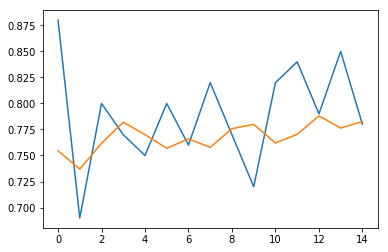

In [6]:
plt.plot(epoch_list, train_acc_list)
plt.plot(epoch_list, test_acc_list)
plt.show()